In [2]:
import sys
!{sys.executable} -m pip install numpy scipy matplotlib scikit-learn nibabel scikit-image


   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   ------------------------- -------------- 2.1/3.3 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 3.3/3.3 MB 10.9 MB/s eta 0:00:00


Copying and compressing raw files...
Compression complete.

🔹 Processing 1BA001 (1/180)
1BA001: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA005 (2/180)
1BA005: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA012 (3/180)
1BA012: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA014 (4/180)
1BA014: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA022 (5/180)
1BA022: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA032 (6/180)
1BA032: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA040 (7/180)
1BA040: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA054 (8/180)
1BA054: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA058 (9/180)
1BA058: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(256, 256)).

🔹 Processing 1BA075 (10/180)
1BA075: 30 slices saved (MRI∈[-1,1], CT∈[-1,1], size=(25

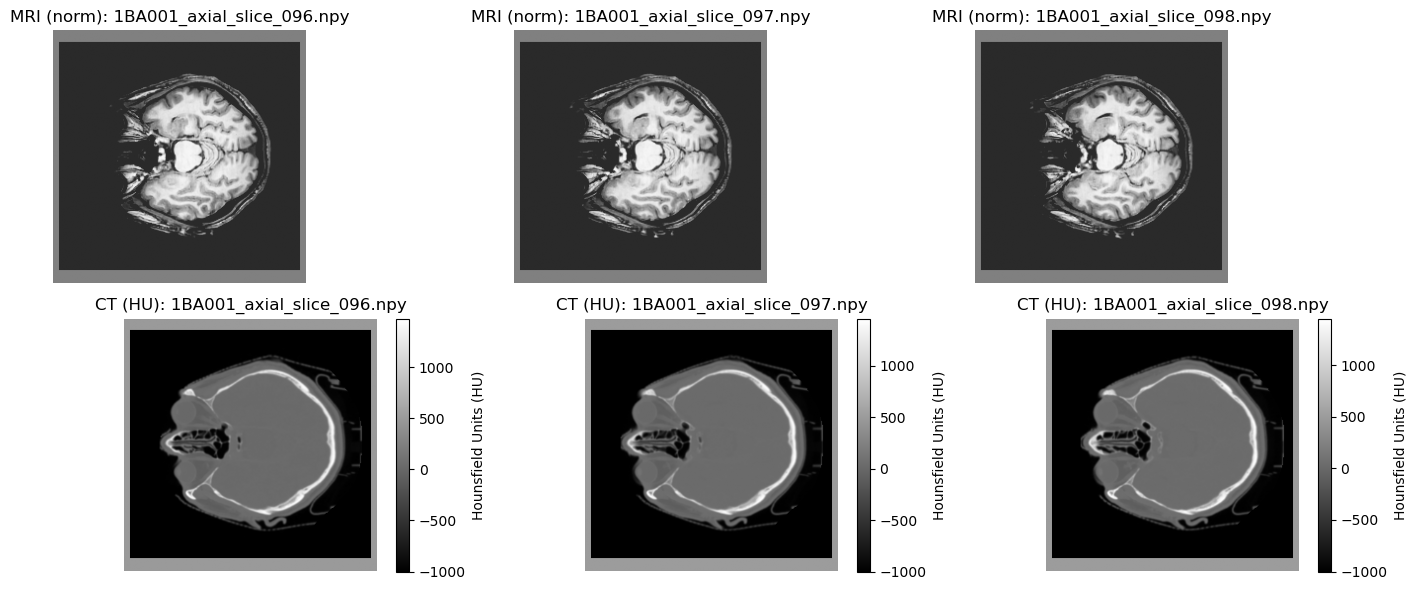

In [5]:
import os
import gzip
import shutil
import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from skimage.filters import threshold_otsu

# =========================
# Step 1: Set Paths
# =========================
src_folder = r"V:\Task1\brain"
base_dir   = r"V:\MRI_CT_Project Final"

mri_dir = os.path.join(base_dir, "MRI")
ct_dir = os.path.join(base_dir, "CT")
output_mri_dir = os.path.join(base_dir, "processed", "MRI_slices")
output_ct_dir = os.path.join(base_dir, "processed", "CT_slices")

for d in [mri_dir, ct_dir, output_mri_dir, output_ct_dir]:
    os.makedirs(d, exist_ok=True)

# =========================
# Step 2: Compress raw NIfTI (with gzip detection)
# =========================
def is_gzipped(file_path):
    with open(file_path, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'

def compress_to_gz(src_path, dst_path):
    with open(src_path, 'rb') as f_in:
        with gzip.open(dst_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

print("Copying and compressing raw files...")
for patient_folder in os.listdir(src_folder):
    patient_path = os.path.join(src_folder, patient_folder)
    if not os.path.isdir(patient_path):
        continue

    for file_name in os.listdir(patient_path):
        src_path = os.path.join(patient_path, file_name)

        if "mr" in file_name.lower():
            dst_path = os.path.join(mri_dir, f"{patient_folder}_MRI.nii.gz")
            if is_gzipped(src_path):
                shutil.copy2(src_path, dst_path)
            else:
                compress_to_gz(src_path, dst_path)

        elif "ct" in file_name.lower():
            dst_path = os.path.join(ct_dir, f"{patient_folder}_CT.nii.gz")
            if is_gzipped(src_path):
                shutil.copy2(src_path, dst_path)
            else:
                compress_to_gz(src_path, dst_path)

print("Compression complete.")

# =========================
# Step 3: Normalization
# =========================

CT_HU_MIN, CT_HU_MAX = -1000.0, 2000.0  # HU range for soft tissue + bone

def ct_hu_to_net(ct_hu):
    """Convert CT in HU to normalized [-1,1]."""
    ct = np.clip(ct_hu.astype(np.float32), CT_HU_MIN, CT_HU_MAX)
    return 2.0 * (ct - CT_HU_MIN) / (CT_HU_MAX - CT_HU_MIN) - 1.0

def net_to_ct_hu(ct_net):
    """Invert normalized [-1,1] CT back to HU."""
    return ((ct_net + 1.0) * 0.5) * (CT_HU_MAX - CT_HU_MIN) + CT_HU_MIN

def normalize_mri_for_synthesis(mri_vol):
    """Robust z-score normalization of MRI, then squash to [-1,1]."""
    vol = mri_vol.astype(np.float32)
    nonzero = vol[vol > 0]
    if nonzero.size < 10:
        return np.zeros_like(vol, dtype=np.float32)

    # mask via Otsu
    t = threshold_otsu(nonzero)
    mask = vol > t

    vox = vol[mask]
    lo, hi = np.percentile(vox, [0.5, 99.5])
    vol = np.clip(vol, lo, hi)

    med = np.median(vox)
    iqr = np.subtract(*np.percentile(vox, [75, 25])) + 1e-6
    z = (vol - med) / iqr

    z = np.tanh(z)
    return z.astype(np.float32)

# =========================
# Step 4: Preprocessing (Resample + Crop 256×256)
# =========================
def resample_to_spacing(vol, src_affine, target_spacing=(1.0,1.0,1.0), order=1):
    zooms = nib.affines.voxel_sizes(src_affine)
    scale = tuple(zooms[i] / target_spacing[i] for i in range(3))
    return zoom(vol, scale, order=order)

def center_crop_or_pad2d(img, out_hw=(256,256), pad_value=0.0):
    H, W = img.shape
    oh, ow = out_hw
    # pad if smaller
    ph = max(0, (oh - H) // 2)
    pw = max(0, (ow - W) // 2)
    img = np.pad(img, ((ph, oh - H - ph if oh > H else 0),
                       (pw, ow - W - pw if ow > W else 0)),
                 mode='constant', constant_values=pad_value)
    # crop if larger
    H, W = img.shape
    sy = max(0, (H - oh) // 2)
    sx = max(0, (W - ow) // 2)
    return img[sy:sy+oh, sx:sx+ow]

def preprocess_and_save_slices(subject_id, top_k = 30, out_size=(256,256)):
    """Convert MRI/CT to aligned axial slices, normalize, resize, and save pairs."""
    try:
        mri_path = os.path.join(mri_dir, f"{subject_id}_MRI.nii.gz")
        ct_path = os.path.join(ct_dir, f"{subject_id}_CT.nii.gz")

        if not os.path.exists(mri_path) or not os.path.exists(ct_path):
            print(f"Missing MRI or CT for {subject_id}, skipping.")
            return 0

        # load & resample
        mri_nii = nib.load(mri_path)
        ct_nii = nib.load(ct_path)
        mri_img = resample_to_spacing(mri_nii.get_fdata(), mri_nii.affine, order=3)
        ct_img = resample_to_spacing(ct_nii.get_fdata(), ct_nii.affine, order=1)

        if mri_img.shape != ct_img.shape:
            print(f"Shape mismatch after resample for {subject_id}: {mri_img.shape} vs {ct_img.shape}")
            return 0

        # normalize
        mri_img = normalize_mri_for_synthesis(mri_img)
        ct_img = ct_hu_to_net(ct_img)

        total_saved = 0
        slice_info = []
        num_slices = mri_img.shape[2]

        for i in range(num_slices):
            mri_slice = mri_img[:,:,i]
            if np.max(mri_slice) > 0.1:  # skip empty
                var = np.var(mri_slice)
                slice_info.append((i, var))

        if not slice_info:
            return 0

        slice_info.sort(key=lambda x: x[1], reverse=True)
        top_slices = [idx for idx,_ in slice_info[:min(top_k, len(slice_info))]]

        for i in top_slices:
            mri_slice = center_crop_or_pad2d(mri_img[:,:,i], out_size)
            ct_slice  = center_crop_or_pad2d(ct_img[:,:,i], out_size)

            slice_name = f"{subject_id}_axial_slice_{i:03d}.npy"
            np.save(os.path.join(output_mri_dir, slice_name), mri_slice.astype(np.float32))
            np.save(os.path.join(output_ct_dir, slice_name), ct_slice.astype(np.float32))
            total_saved += 1

        print(f"{subject_id}: {total_saved} slices saved (MRI∈[-1,1], CT∈[-1,1], size={out_size}).")
        return total_saved

    except Exception as e:
        print(f"Error processing {subject_id}: {e}")
        return 0

# =========================
# Step 5: Process all subjects + Split
# =========================
mri_files = [f for f in os.listdir(mri_dir) if f.endswith('_MRI.nii.gz')]
subject_ids = [f.replace('_MRI.nii.gz', '') for f in mri_files]

total_slices = 0
for idx, sid in enumerate(subject_ids):
    print(f"\n🔹 Processing {sid} ({idx+1}/{len(subject_ids)})")
    total_slices += preprocess_and_save_slices(sid, top_k=30)

print(f"\nTotal best axial slices saved: {total_slices}")

paired_files = sorted(list(set(os.listdir(output_mri_dir)) & set(os.listdir(output_ct_dir))))
total_processed = len(paired_files)

if total_processed > 0:
    indices = list(range(total_processed))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=42)

    split_dict = {
        "train": train_idx,
        "val": val_idx,
        "test": test_idx,
        "files": paired_files,
        "total_slices": total_processed
    }

    split_path = os.path.join(base_dir, "processed", "split_indices.json")
    with open(split_path, "w") as f:
        json.dump(split_dict, f, indent=2)

    print(f"Splits saved to {split_path}")
    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
else:
    print("No paired slices found for splitting.")

# =========================
# Step 6: Visualization
# =========================
def visualize_sample_slices(num_samples=3):
    paired_files = sorted(list(set(os.listdir(output_mri_dir)) & set(os.listdir(output_ct_dir))))

    if not paired_files:
        print("No paired slices to visualize.")
        return

    paired_files = paired_files[:num_samples]
    fig, axs = plt.subplots(2, len(paired_files), figsize=(5 * len(paired_files), 6))

    for i, fname in enumerate(paired_files):
        mri_img = np.load(os.path.join(output_mri_dir, fname))
        ct_net  = np.load(os.path.join(output_ct_dir, fname))

        # MRI normalized [-1,1]
        axs[0, i].imshow(mri_img, cmap='gray', vmin=-1, vmax=1)
        axs[0, i].set_title(f"MRI (norm): {fname}")
        axs[0, i].axis('off')

        # CT inverted back to HU
        ct_hu = net_to_ct_hu(ct_net)
        im = axs[1, i].imshow(ct_hu, cmap='gray')
        axs[1, i].set_title(f"CT (HU): {fname}")
        axs[1, i].axis('off')

        cbar = plt.colorbar(im, ax=axs[1, i], fraction=0.046, pad=0.04)
        cbar.set_label("Hounsfield Units (HU)")

    plt.tight_layout()
    plt.show()

# Show a few samples
visualize_sample_slices()
